In [1]:
import multiprocessing as mp
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import DMdecay as dmd
import JWSTutils as jwst
from gnz11_split import partition_gnz11

In [2]:
run_dir = "gnz11_split"
prev_config_path = F"{run_dir}/gnz11_split.toml"
skipping = 1

dofs = [5, 15]

In [3]:
prev_configs = dmd.prep.parse_configs(prev_config_path)
run_name = prev_configs["run"]["name"]

data = jwst.process_datafiles(prev_configs["run"]["paths"], 
                                prev_configs["system"]["res_path"])
data = partition_gnz11(data, prev_configs["run"]["lambda_min"],
                        prev_configs["run"]["lambda_split"])
for spec in data:
    dmd.prep.doppler_correction(spec, prev_configs["halo"])
    dmd.prep.add_Dfactor(spec, prev_configs["halo"])

parsing gnz11_split/gnz11_split.toml
processing 2 datafiles...


In [4]:
rawlimits = np.loadtxt(
    F"{run_name}/{prev_configs['run']['rawlimits_filename']}")
valid = np.isfinite(rawlimits[:, 1])
masses_to_test = rawlimits[valid, :][::skipping, 0]
lams_to_test = dmd.conversions.mass_to_wavelength(masses_to_test)

In [5]:
def get_limit(num_knots, data, prev_configs, lam_test):
    prev_configs["analysis"]["num_knots"] = num_knots
    raw_out = dmd.linesearch.find_raw_limit(prev_configs, data, lam_test)
    [[lmin, lmax], 
    spec_list, 
    knots, 
    error_scale_factors,
    [limit_rate, limit_knots], 
    [best_rate, best_knots],
    delta_chisq,
    lam_list_msk, 
    error_list_msk, 
    lam0_tmp,
    sky_list, 
    lam_list, 
    error_list, 
    fixed_list, 
    spec_list, 
    res_list, 
    mask_list, 
    sky_list_msk] = raw_out
    limit_decayrate = dmd.conversions.fluxscale_to_invsec(limit_rate)   
    mass_test = dmd.conversions.wavelength_to_mass(lam_test)
    limit_g = dmd.conversions.decayrate_to_axion_g(limit_decayrate,
                                                    mass_test) 
    return limit_g

In [6]:
limits_dict = {n:np.full(masses_to_test.size, np.nan) for n in dofs}
for i, num_knots in enumerate(dofs):
    print(F"Fitting with {num_knots} knots")
    wrapper = partial(get_limit, num_knots, data, prev_configs)
    with mp.Pool(mp.cpu_count() - 1) as pool:
        results_iter = tqdm(pool.imap(wrapper, lams_to_test), 
                        total=lams_to_test.size)
        limits_dict[num_knots] = np.asarray(list(results_iter))

Fitting with 5 knots


100%|██████████| 905/905 [00:42<00:00, 21.40it/s]

Fitting with 15 knots



100%|██████████| 905/905 [03:32<00:00,  4.26it/s]


In [22]:

limits_df = pd.DataFrame(limits_dict)
limits_df["mass"] = masses_to_test
avg = (limits_df[5] + limits_df[15])*0.5
limits_df["frac_diff"] = (limits_df[5] - limits_df[15])/avg

limits_df["ratio"] = limits_df[5]/limits_df[15]
limits_df["log_ratio"] = np.log10(limits_df["ratio"])
limits_df["lam"] = lams_to_test

In [13]:

limits_df.to_csv(F"{run_name}/continuum-compare-limits.csv", index=False)

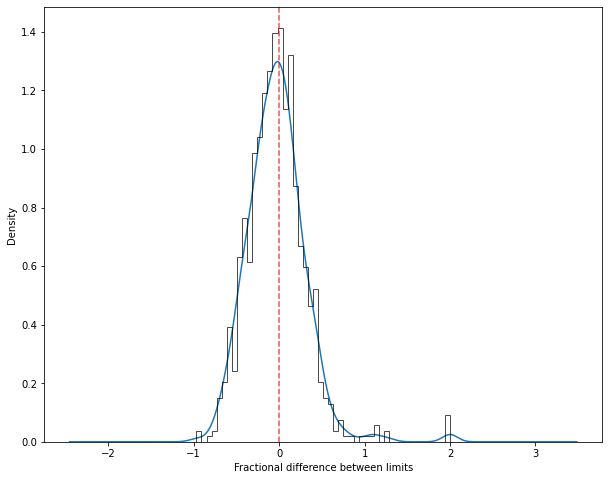

In [9]:
ax = limits_df["frac_diff"].plot(kind="density",
                                 figsize=(10, 8))
ax.hist(limits_df["frac_diff"], bins=50, density=True,
        alpha=0.7, color='black', histtype="step")
ax.set_xlabel("Fractional difference between limits")
ax.axvline(0, color="red", linestyle="--", alpha=0.7)
plt.savefig(F"{run_name}/continuum-compare-limits.png")

In [14]:
np.abs(limits_df["log_ratio"]).quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])

0.100    0.014745
0.250    0.042335
0.500    0.088874
0.750    0.161792
0.900    0.227352
0.990    0.543656
0.999    6.438526
Name: log_ratio, dtype: float64

In [19]:
select_O1 = np.abs(limits_df["log_ratio"]) < 1
O1_logratios = limits_df[select_O1]["log_ratio"]

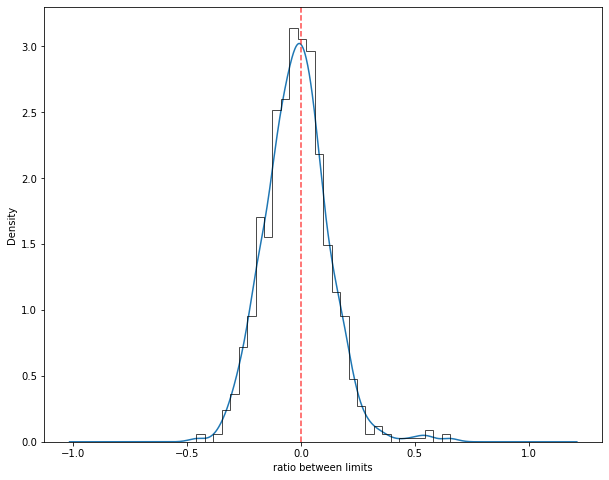

In [20]:
ax_ratio = O1_logratios.plot(kind="density",
                                 figsize=(10, 8))
ax_ratio.hist(O1_logratios, bins=30, density=True,
        alpha=0.7, color='black', histtype="step")
ax_ratio.set_xlabel("ratio between limits")
ax_ratio.axvline(0, color="red", linestyle="--", alpha=0.7)
plt.savefig(F"{run_name}/continuum-compare-limits-ratio.png")

In [24]:
print(F"number of extreme ratio: {np.sum(~select_O1)}\n"
      F"     frac extreme ratio: {np.sum(select_O1)/select_O1.size}")
limits_df[~select_O1][["lam", 5, 15, "ratio"]]

number of extreme ratio: 5
     frac extreme ratio: 0.994475138121547


,lam,5,15,ratio
93,1.144249,1.583057e-11,1.027056e-19,1.541353e+08
397,1.735015,1.612008e-11,9.007739e-18,1.789581e+06
402,1.746048,2.390545e-11,1.569768e-17,1.522865e+06
519,2.019095,1.698105e-11,1.372384e-17,1.237340e+06
676,2.435817,3.443288e-11,8.318613e-17,4.139257e+05


In [27]:
limits_df[select_O1].sort_values("log_ratio", key=np.abs, ascending=False).head(15)

,5,15,mass,frac_diff,ratio,log_ratio,lam
58,2.387505e-11,5.288295e-12,2.284762,1.274665,4.514697,0.654629,1.085312
13,2.299332e-11,5.115729e-12,2.450887,1.272017,4.494632,0.652694,1.011748
40,2.099188e-11,5.745449e-12,2.349081,1.140460,3.653653,0.562727,1.055596
682,3.603206e-11,1.005684e-11,1.010868,1.127179,3.582842,0.554228,2.453021
410,2.212963e-11,6.311601e-12,1.405870,1.112331,3.506183,0.544835,1.763804
16,2.825177e-11,8.623240e-12,2.439242,1.064598,3.276236,0.515375,1.016578
446,2.555208e-11,8.210629e-12,1.343769,1.027255,3.112074,0.493050,1.845317
904,2.376431e-11,6.838837e-11,0.783089,-0.968481,0.347491,-0.459057,3.166536
457,1.392542e-11,3.932298e-11,1.325493,-0.953928,0.354129,-0.450838,1.870761
607,3.181400e-11,1.144491e-11,1.104550,0.941729,2.779751,0.444006,2.244968
